In [1]:
import numpy as np 
import pandas as pd 

import os
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential,Model
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization,Input,UpSampling2D
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras import layers
from keras import regularizers

In [2]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [3]:
img_width, img_height = (256, 256)

In [3]:
def preprocess_img(img_path):
    dsize = (224,224)
    new_image=cv2.imread(img_path)
    new_image=cv2.resize(new_image,dsize)  
    new_image=np.expand_dims(new_image,axis=0)
    new_image=np.flip(new_image,axis=-1)
    return new_image

In [4]:
#dir=os.listdir('dataset/database-full/')

In [5]:
#cosa=[preprocess_img("dataset/database-full/"+x) for x in dir]

# Auto Encoder RGB

In [4]:
input_img = keras.Input(shape=(img_width, img_height, 3))

x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(16, (1, 1), activation='relu')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(3, (2, 2), activation='sigmoid', padding='same')(x)

autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [5]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 8)       1160      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 8)        0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 8)         584   

In [6]:
datagen = ImageDataGenerator(rescale=1./255)
img_data=datagen.flow_from_directory('dataset', target_size=(img_width, img_height), class_mode='input')

Found 31783 images belonging to 1 classes.


In [7]:
autoencoder.fit(img_data, epochs = 5)

Epoch 1/5
994/994 [==============================] - 175s 173ms/step - loss: 0.5423 - accuracy: 0.5700
Epoch 2/5
994/994 [==============================] - 173s 174ms/step - loss: 0.5248 - accuracy: 0.6601
Epoch 3/5
994/994 [==============================] - 172s 173ms/step - loss: 0.5230 - accuracy: 0.6669
Epoch 4/5
994/994 [==============================] - 172s 173ms/step - loss: 0.5215 - accuracy: 0.7045
Epoch 5/5
994/994 [==============================] - 173s 174ms/step - loss: 0.5203 - accuracy: 0.7490


# Guardar modelo

In [8]:
encoder = keras.Model(input_img, encoded)
encoder.save('encoder.h5')
autoencoder.save('autoencoder.h5')

In [9]:
datagen  = ImageDataGenerator(rescale=1./255)
img_data = datagen.flow_from_directory('dataset', target_size=(img_width, img_height), class_mode='input', batch_size=4)

#encoder = keras.models.load_model('encoder.h5')

Found 31783 images belonging to 1 classes.


# Guardar espacio latente

In [10]:
preds_color = encoder.predict(img_data, verbose=1, max_queue_size=4)

7946/7946 [==============================] - 151s 19ms/step


In [15]:
np.save('preds.npy', preds_color)

# Aqui me puse a jugar - se puede borrar -------------------------------------

In [58]:
datagen  = ImageDataGenerator(rescale=1./255)
img_data = datagen.flow_from_directory('test', target_size=(img_width, img_height), class_mode='input')
pred_draw = encoder.predict(img_data)

Found 1 images belonging to 1 classes.


In [59]:
from sklearn.metrics.pairwise import paired_euclidean_distances
from tqdm import tqdm

final_distances = []
  
for j in tqdm (range(31783)):
    distances = []
    for i in range(8):
        d = paired_euclidean_distances(preds_color[j,:,:,i], pred_draw[0,:,:,i])
        distances.append(sum(d))
    final_distances.append(sum(distances))

100%|██████████████████████████████████████████████████████████████████████████| 31783/31783 [00:26<00:00, 1218.93it/s]


In [69]:
dir_ = os.listdir('dataset/database-full/')
df = pd.DataFrame({'dir':dir_, 'distance': final_distances})

In [70]:
df.sort_values(by='distance').reset_index(drop=True).loc[0].dir

' image9860.jpg'

# Hasta aqui se puede eliminar - para abajo no ----------------------------------------

In [10]:
data_generator3 = ImageDataGenerator(rescale=1./255, fill_mode='nearest')

kwargs = {'class_mode': 'input', 'subset':None, 'shuffle':False, 'seed':1, 'target_size':(img_height, img_width)}
image_generator3 = data_generator3.flow_from_directory('copia_borrar', **kwargs)

preds_color = autoencoder.predict(image_generator3)

Found 4 images belonging to 1 classes.


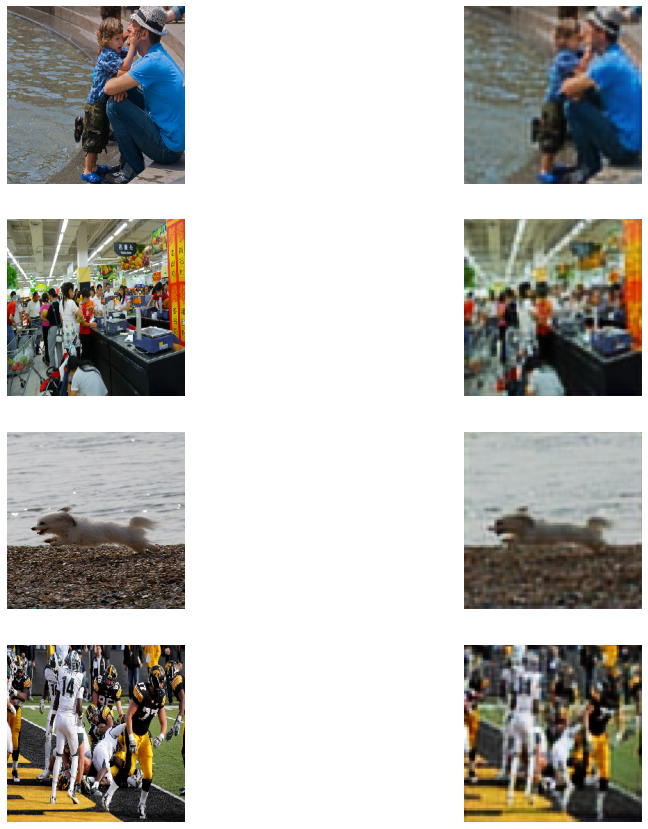

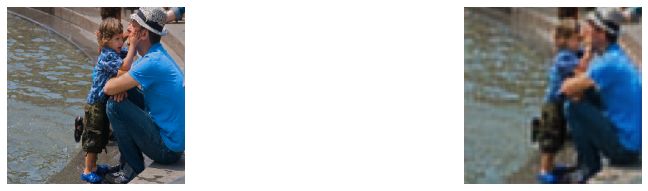

In [11]:
stop = 0
for x in image_generator3.next():
    plt.figure(figsize=(15,15))
    for x_, pred, i in zip(x, preds_color, range(1, 1+2*len(preds_color), 2)):
        if(stop > 4):
            break
        
        plt.subplot(4, 2, i)
        plt.imshow(x_)
        plt.axis("off")
        
        plt.subplot(4, 2, i+1)
        plt.imshow(pred)
        plt.axis("off")
        
        stop += 1
